# Monte Carlo Tree Search (MCTS)

## Overview
Monte Carlo Tree Search (MCTS) is a powerful algorithm used for decision-making in games and other sequential action problems. It combines random sampling (Monte Carlo methods) with systematic tree search to balance exploration and exploitation, making it effective in environments with large search spaces.

## Key Steps of MCTS
MCTS operates through four main steps, which are repeated iteratively:

1. **Selection**
   - Start from the root node and recursively select the **best child node** based on a selection policy (e.g., Upper Confidence Bound for Trees, UCT).
   - The selection favors nodes with a high reward estimate and encourages exploration of less-visited nodes.

2. **Expansion**
   - If the selected node is not a terminal state and has unexplored actions, a new child node is added to the tree.
   
3. **Simulation (Rollout)**
   - A **random** or **heuristic-based** simulation is run from the newly expanded node until a terminal state is reached.
   - The outcome (e.g., win/loss/draw or accumulated reward) is recorded.

4. **Backpropagation**
   - The result of the simulation is propagated back through the visited nodes, updating their visit count and value estimate.
   
## Upper Confidence Bound (UCB1) Formula
A common selection strategy in MCTS is **UCB1**, which balances exploitation and exploration:

$$ 
UCB_1 = \frac{w_i}{n_i} + C \sqrt{\frac{\ln N}{n_i}} 
$$

where:
- $ w_i $ = total reward of node $ i $
- $ n_i $ = visit count of node $ i $
- $ N $ = total visit count of parent node
- $ C $ = exploration constant (typically set to $\sqrt{2}$ or tuned experimentally)

In [78]:
import gymnasium as gym
import numpy as np
from math import log, sqrt
import random
from gymnasium.spaces import Discrete
import sys
import pygame
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange
from infrastructure.notebook_util import *
from copy import deepcopy

# For most gymnasium environments, there is not option to set to a given state
# We have to create deepcopies to run MCTS

class MCTSNode:
    def __init__(self, env, state, parent=None, action=None):
        assert isinstance(env.action_space, Discrete), "Continuous action space is not supported."
        self.state = state
        self.env = deepcopy(env)
        self.parent = parent
        self.action = action  # Action that led to this node
        self.children = []
        self.visits = 0
        self.value = 0
        self.untried_actions = list(range(env.action_space.n))  # Actions

    def expanded(self):
        return len(self.untried_actions)==0

    def get_child(self, exp_weight=2.0):
        """Select the best child based on UCB1 score."""
        return max(
            self.children, 
            key=lambda child: (child.value / (child.visits + 1e-6)) + exp_weight * sqrt(log(self.visits + 1) / (child.visits + 1e-6))
        )

    def update(self, reward):
        """Update node statistics."""
        self.visits += 1
        self.value += reward

def update(node, reward):
    while node:
        node.update(reward)
        node = node.parent

def rollout(env, state):
    """Simulate a random game from the current state."""
    total_reward = 0
    done = False
    env_copy = deepcopy(env)
    
    while not done:
        action = env_copy.action_space.sample()  # Random action
        _, reward, terminated, truncated, _ = env_copy.step(action)
        total_reward += reward
        done = terminated or truncated
    env_copy.close()
    return total_reward

class MCTS:
    def __init__(self, env, state):
        self.root = MCTSNode(env, state)
            
    def run(self, n_iters, eval_iters):
        for i in range(n_iters):
            if eval_iters!=-1 and (i+1) % eval_iters == 0:
                plot_mcts_tree(self.root)
            node = self.root
            env_copy = copy.deepcopy(self.root.env)
            reward = 0
            while node.expanded() and len(node.children) > 0:
                node = node.get_child()
                action = node.action
                next_state, reward, terminated, truncated, _ = env_copy.step(action)
                
            if not node.expanded():
                action = node.untried_actions.pop()
                next_state, reward, terminated, truncated, _ = env_copy.step(action)
                child = MCTSNode(env_copy, next_state, node, action)
                node.children.append(child)
                node = child
                done = terminated or truncated
                if done: # reaching a terminal state
                    node.untried_actions = [] # terminal state do not have any valid actions
                    update(node, reward)
                    # node is either not fully expanded, or does not have any child
                    continue
            else: # node is fully expanded but has no child, must be reaching a terminal state
                update(node, reward)
                continue
            
            tot_rewards = rollout(env_copy, node.state)
            update(node, tot_rewards)
            env_copy.close()
        
        return self.root.get_child(exp_weight=0).action 
                

def transfer_tree(root, selected_action):
    """Transfer tree information to the next state by making the selected child the new root."""
    for child in root.children:
        if child.action == selected_action:
            child.parent = None  # Remove reference to the old root
            return child  # New root with retained subtree
    return MCTSNode(root.state.perform_move(selected_action))  # If child not found, start fresh


action_map = {0:"L", 1:"D", 2:"R", 3:"U"}

def plot_mcts_tree(root, max_depth=1):
    """
    Visualizes the MCTS tree using NetworkX and Matplotlib.

    Parameters:
        root (MCTSNode): The root of the MCTS tree.
        max_depth (int): Maximum depth to display (for clarity).
    """
    G = nx.DiGraph()  # Directed graph for the tree
    node_labels = {}  # Dictionary for labeling nodes

    def add_edges(node, depth=0):
        """Recursive function to add edges and nodes to the graph."""
        node_id = id(node)  # Unique ID for each node
        G.add_node(node_id)
        action = action_map[node.action] if node.action is not None else None
        node_labels[node_id] = f"N:{node.visits},R:{int(node.value)},S:{node.state},A:{action}"

        if depth >= max_depth:
            return
        
        for child in node.children:
            child_id = id(child)
            G.add_edge(node_id, child_id)
            add_edges(child, depth + 1)

    add_edges(root)

    # Plot the tree
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    nx.draw(G, pos, with_labels=False, node_size=4000, node_color="lightblue", edge_color="gray")
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_weight="bold")

    plt.title("Monte Carlo Tree Search (MCTS) Tree Visualization")
    plt.show()

In [4]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")  # Needed for rendering
env = wrap_env(env)

env.reset()
for _ in range(100):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())  # Take random actions
    if terminated or truncated:
        obs, _ = env.reset()

env.close()

print('Loading video...')
show_video(env)

/Users/hyan/anaconda3/envs/RL/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/hyan/Downloads/RL/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Loading video...
video/FrozenLake-v1*.mp4


Initial state:  0


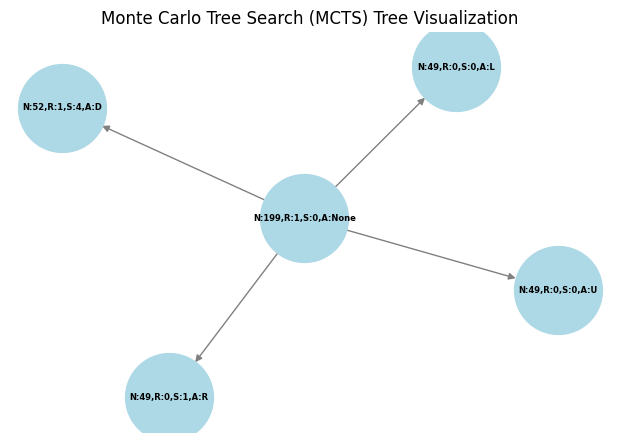

Step 1: 4
Reward: 0.0   


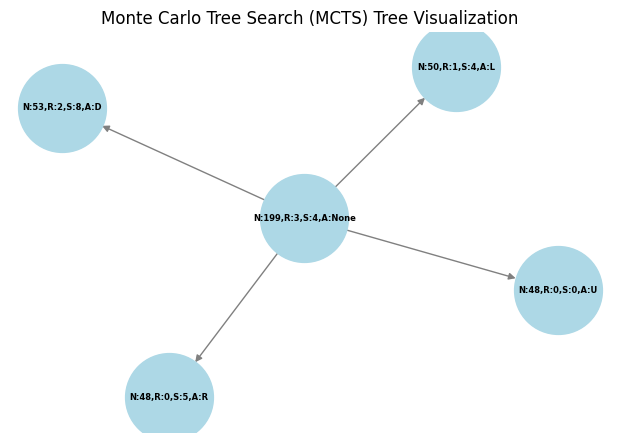

Step 2: 8
Reward: 0.0   


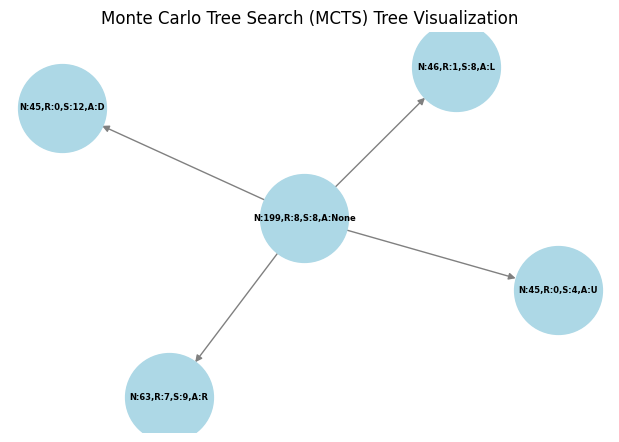

Step 3: 9
Reward: 0.0   


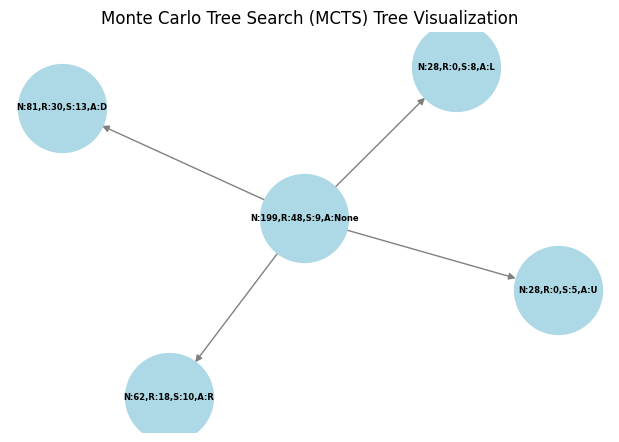

Step 4: 13
Reward: 0.0   


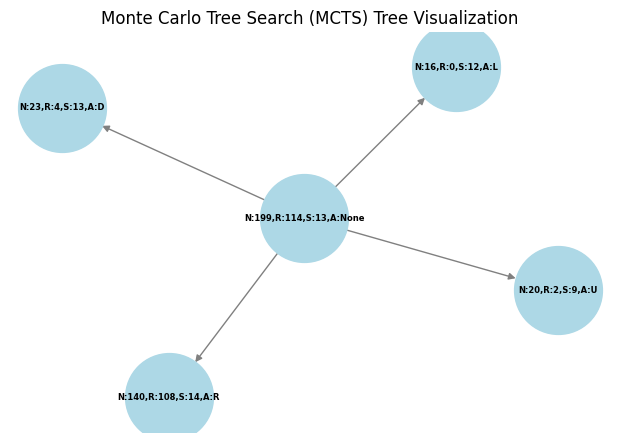

Step 5: 14
Reward: 0.0   


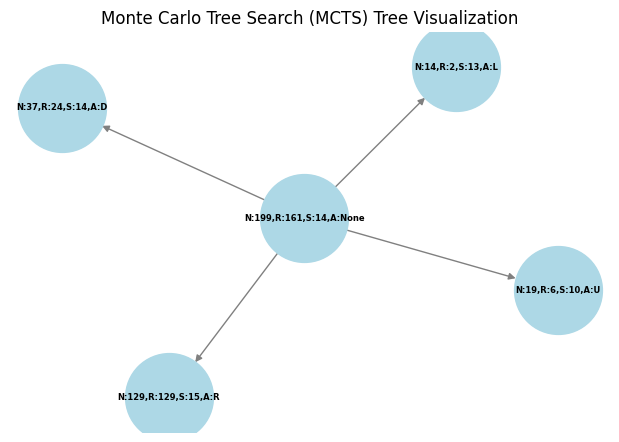

Step 6: 15
Reward: 1.0   
['D', 'D', 'R', 'D', 'R', 'R']


In [82]:
# Running Naive MCTS on CartPole, every step create a new MCTS Node.
# Unfortunately, since pygame.surface.Surface is not serializable, 
# we cannot set render_mode = "human" and see how MCTS plays out.
env = gym.make("FrozenLake-v1", render_mode=None, is_slippery=False)  
state, _ = env.reset()
done = False
tot_reward = 0
actions = []
print("Initial state: ", state)
steps = 0
while not done:
    tree = MCTS(env, state)
    best_action = tree.run(n_iters=200, eval_iters=200)
    state, reward, terminated, truncated, _ = env.step(best_action)
    done = terminated or truncated
    steps += 1
    print(f"Step {steps}: {state}")
    #transfer_tree(root, best_action)
    tot_reward += reward
    print(f"Reward: {tot_reward}   ")
    actions.append(action_map[best_action])
env.close()
print(actions)